Discard: Image reconstruction via marginal posteriors to wavelet basis

In [ ]:
import torch
import swyft
import pylab as plt
import numpy as np
import scipy
import swyft

## Helper functions

### Statistics

In [ ]:
def logdiffcdf(dist, a, b):
    if dist.cdf(b) < 0.5:
        return np.log(dist.cdf(b) - dist.cdf(a))
    else:
        return np.log(dist.sf(a) - dist.sf(b))
    
def logdiffcdf(dist, a, b):
    return np.where(dist.cdf(b) < 0.5,
        np.log(dist.cdf(b) - dist.cdf(a)),
        np.log(dist.sf(a) - dist.sf(b))
            )

def trunc_sample(dist, r, size = None, return_logdiffcdf = True):
    r = np.array(r)
    c = dist.cdf(r)
    s = scipy.stats.uniform(loc = c[...,0], scale = c[...,1] - c[...,0]).rvs(size=size)
    z = np.array(dist.ppf(s))
    if not return_logdiffcdf:
        return z
    else:
        l = logdiffcdf(dist, r[...,0], r[...,1])
        return z, l
    
def get_trunc_draws(Ntrials, truncs):
    draws = [trunc_prior(truncs) for _ in range(Ntrials)]
    weights = np.array([v['weight'] for v in draws])
    mask = weights/weights.max() > np.random.rand(len(weights))
    return [draws[i] for i in np.arange(Ntrials)[mask]]

### SWYFT Modeling

In [3]:
from swyft.utils.array import array_to_tensor
class SimpleDataset(torch.utils.data.Dataset):                                                                                                                                                 
    """Dataset which merely keeps track of observation and parameter data in one place"""                                                                                                      
                                                                                                                                                                                               
    def __init__(self, observations, us, vs) -> None:                                                                                                                   
        """                                                                                                                                                                                    
        Args:                                                                                                                                                                                  
            observations: dictionary of batched obserations                                                                                                                                    
            us: array or tensor of unit cube parameters                                                                                                                                        
            vs: array or tensor of natural parameters                                                                                                                                          
        """                                                                                                                                                                                    
        super().__init__()                                                                                                                                                                     
        b = us.shape[0]                                                                                                                                                                        
        assert (                                                                                                                                                                               
            vs.shape[0] == b                                                                                                                                                                   
        ), "the us and vs arrays do not have the same batch dimension"                                                                                                                         
        assert all(                                                                                                                                                                            
            [b == x.shape[0] for x in observations.values()]                                                                                                                                   
        ), "the observation values do not have the same batch dimension as us and vs"                                                                                                          
        self.observations = observations                                                                                                                                                       
        self.us = us                                                                                                                                                                           
        self.vs = vs                                                                                                                                                                           
        self._len = b           
        
    def pnames(self):
        return None
    
    def prior(self):
        return None
    
    def bound(self):
        return None
    
    @property
    def requires_sim(self):
        return False
                                                                                                                                                                                               
    def __getitem__(self, idx):
        return (                                                                                                                                                                               
            {                                                                                                                                                                                  
                key: array_to_tensor(val[idx, ...])                                                                                                                                            
                for key, val in self.observations.items()                                                                                                                                      
            },                                                                                                                                                                                 
            array_to_tensor(self.us[idx, ...]),                                                                                                                                                
            array_to_tensor(self.vs[idx, ...]),                                                                                                                                                
        )                                                                                                                                                                                      
                                                                                                                                                                                               
    def __len__(self) -> int:                                                                                                                                                                  
        return self._len

In [4]:
class DistributionRatio(torch.nn.Module):
    def __init__(self, dist, *shape):
        super().__init__()
        self.dist = dist
        self.log_prefactor = torch.nn.Parameter(torch.zeros(*shape))
        self.log_scale = torch.nn.Parameter(torch.zeros(*shape))
        
    def bounds(self, m, epsilon):
        scale = torch.exp(self.log_scale)
        r0 = torch.zeros_like(m) + epsilon
        b0 = self.dist(m, scale).icdf(r0)
        #b1 = self.dist(m, scale).icdf(r1)
        return b0
    
    def forward(self, z, m, return_bounds = None):
        if return_bounds:
            return self.bounds(m, return_bounds)
        scale = torch.exp(self.log_scale)
        log_ratio = self.dist(m, scale).log_prob(z) + self.log_prefactor
        return log_ratio

In [5]:
class View:
    def __init__(self, **shapes):
        self._shapes = shapes
        self._i0 = {}
        self._i1 = {}
        
        N = 0
        for key, value in shapes.items():
            n = np.prod(value)
            self._i0[key] = N
            self._i1[key] = N + n
            N += n
        
        self._N = N
        
    def __len__(self):
        return self._N

class Viewer:
    def __init__(self, view, u):
        self._view = view
        self._u = u
        
    def __getattr__(self, key):
        ucut = self._u[..., self._view._i0[key]:self._view._i1[key]]
        if type(ucut) == np.ndarray:
            return ucut.reshape(*self._u.shape[:-1], *self._view._shapes[key])  # TODO Redunadnt
        else:
            return ucut.reshape(*self._u.shape[:-1], *self._view._shapes[key])
    
    def __setattr__(self, key, value):
        if key[:1] == '_':
            object.__setattr__(self, key, value)
        else:
            if type(value) == np.ndarray:
                value_shaped = value.reshape(*self._u.shape[:-1], np.prod(self._view._shapes[key]))  # TODO Redundant
            else:
                value_shaped = value.reshape(*self._u.shape[:-1], np.prod(self._view._shapes[key]))
            self._u[..., self._view._i0[key]:self._view._i1[key]] = value_shaped
    
    def __len__(self):
        return self._view._N
    
    def __call__(self):
        return self._u

## Model definition

In [6]:
from astropy import convolution as ac
import numpy as np
import pylab as plt

In [7]:
def convolve(coef, size):
    img = np.zeros(size)
    for c in coef:
        k = len(c)
        n = len(img)
        base = np.zeros_like(img)
        base[int(n/k/2)::int(n/k), int(n/k/2)::int(n/k)] = c*(n/k)**4
        kernel = ac.RickerWavelet2DKernel(1.8*n/k)
        base = ac.convolve_fft(base, kernel, normalize_kernel = False)
        img += base
    return img

In [8]:
SIGMA = 0.01  # Measurement uncertainty

In [9]:
def prior():
    z1 = scipy.stats.norm(0, 1).rvs((4, 4))
    z2 = scipy.stats.norm(0, 1).rvs((8, 8))
    z3 = scipy.stats.norm(0, 1).rvs((16, 16))
    return dict(z1 = z1, z2 = z2, z3 = z3)

def trunc_prior(truncs):
    z1 = trunc_sample(scipy.stats.norm(0, 1), truncs['z1'], return_logdiffcdf = False)
    z2 = trunc_sample(scipy.stats.norm(0, 1), truncs['z2'], return_logdiffcdf = False)
    z3 = trunc_sample(scipy.stats.norm(0, 1), truncs['z3'], return_logdiffcdf = False)
    return dict(z1 = z1, z2 = z2, z3 = z3, weight = 1.)

In [10]:
truncs = np.zeros((4, 4, 2))+0.1
truncs[:, :,1] = 0.9
trunc_sample(scipy.stats.norm(0, 1), truncs, return_logdiffcdf = False)

array([[0.49025488, 0.18356256, 0.31775375, 0.6472127 ],
       [0.44876576, 0.53787225, 0.18194321, 0.6397832 ],
       [0.61823882, 0.20373125, 0.14808395, 0.12735842],
       [0.18615512, 0.33219126, 0.3390159 , 0.72276705]])

In [11]:
view = View(z1 = (4,4), z2 = (8, 8), z3 = (16, 16))
NPAR = len(view)

In [12]:
def model(v):
    vv = Viewer(view, v)
    coef = [vv.z1, vv.z2, vv.z3]
    x = convolve(coef, (32, 32))
    return dict(x=x)

In [13]:
# Noise model
def noise(sim, v):
    x = sim['x']
    noise = np.random.randn(*x.shape)*SIGMA
    return dict(x = sim['x'] + noise)

def transform(u):
    return u

## Network

In [30]:
class RatioSampler(swyft.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rz1 = DistributionRatio(torch.distributions.Normal, (4,4))
        self.rz2 = DistributionRatio(torch.distributions.Normal, (8,8))
        self.rz3 = DistributionRatio(torch.distributions.Normal, (16,16))
        
        # 2n x 2n image --> n x n estimates
        self.get_mz1 = torch.nn.Sequential(
            torch.nn.AvgPool2d(4),
            torch.nn.Conv2d(1, 32, 5, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 5, padding = 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, 1, padding = 0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 1, 1, padding = 0),
        )
        self.get_mz2 = torch.nn.Sequential(
            torch.nn.AvgPool2d(2),
            torch.nn.Conv2d(1, 32, 5, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 5, padding = 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, 1, padding = 0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 1, 1, padding = 0),
        )
        self.get_mz3 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 5, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 5, padding = 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, 1, padding = 0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 1, 1, padding = 0),
        )
    
    def embedding(self, x):
        return x

    def forward(self, x, u, return_bounds = None):
        uv = Viewer(view, u)
        nbatch = len(x)
        
        mz1 = self.get_mz1(x.unsqueeze(1)).squeeze(1)
        mz2 = self.get_mz2(x.unsqueeze(1)).squeeze(1)
        mz3 = self.get_mz3(x.unsqueeze(1)).squeeze(1)
        
        rz1 = self.rz1(uv.z1, mz1, return_bounds = return_bounds)
        rz2 = self.rz2(uv.z2, mz2, return_bounds = return_bounds)
        rz3 = self.rz3(uv.z3, mz3, return_bounds = return_bounds)
        
        rz1 = rz1.view(nbatch, -1)
        rz2 = rz2.view(nbatch, -1)
        rz3 = rz3.view(nbatch, -1)
        
        r = torch.hstack([rz1, rz2, rz3])
        return r

In [22]:
from tqdm import tqdm

## Analysis

In [23]:
NTRAIN = 10000

def get_prior_samples():
    s = np.zeros((NTRAIN, NPAR))
    vu = Viewer(view, s)
    for i in tqdm(range(len(s))):
        p = prior()
        vu.z1[i] = p['z1']
        vu.z2[i] = p['z2']
        vu.z3[i] = p['z3']
    return s

s = get_prior_samples()

100%|██████████| 10000/10000 [00:20<00:00, 497.15it/s]


In [17]:
# Set dataset

observations = {"x": np.array([noise(model(s[i]), s[i])['x'] for i in tqdm(range(len(s)))])}
dataset = SimpleDataset(observations, s, s)

100%|██████████| 10000/10000 [03:22<00:00, 49.49it/s]


In [59]:
class MyHead(swyft.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.n_features = 1
        self.o = swyft.OnlineNormalizationLayer((32, 32))
    
    def forward(self, obs):
        return self.o(obs['x'])

In [31]:
# Generate posterior estimator

post = swyft.Posteriors(dataset)
partition = range(NPAR)
post.add(partition, device='cuda', head_args = dict(online_norm = False), tail = RatioSampler, head = MyHead)

In [32]:
# train!

post.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 64, optimizer_args = dict(lr = 0.01))

Training: lr=7.8e-05, Epoch=27, VL=446, TL=445.24


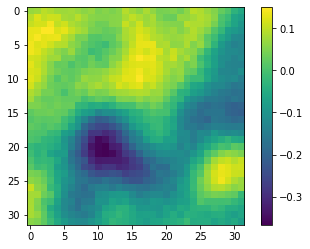

In [33]:
# Pick some reference example

I = 20
x0, u0, _ = dataset[I:I+1]
x0 = x0['x'].cuda()
X0 = x0.cpu()[0]
u0 = u0.cuda()

plt.imshow(x0.cpu()[0])
plt.colorbar()

In [62]:
# Extract bounds from the tail

tail = list(post._ratios.items())[0][1].tail
b0 = tail.forward(x0, u0, return_bounds = 0.1)
b1 = tail.forward(x0, u0, return_bounds = 0.9)
b = torch.vstack([b0, b1])
z_trunc = b.T.cpu().detach().numpy()
#z_trunc = b[:, :N].cpu().detach().numpy().T

In [67]:
#z_trunc[:-33,:] *= 0.001
trunc = dict(z1 = z_trunc[:4*4, :].reshape(4, 4, 2), z2 = z_trunc[4*4:4*4+8*8, :].reshape(8, 8, 2), z3 = z_trunc[4*4+8*8:, :].reshape(16, 16, 2))
draws = get_trunc_draws(100, trunc)

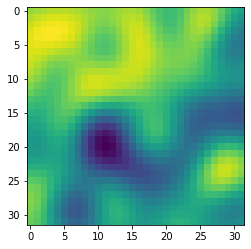

In [68]:
x = np.zeros((32, 32))
for i in range(100):
    d = draws[i]
    u = np.zeros(NPAR)
    v = Viewer(view, u)
    v.z1 = d['z1']
    v.z2 = d['z2']
    v.z3 = d['z3']
    x += model(u)['x']
x /= 100
plt.imshow(x)

## Round 2

In [69]:
NTRAIN = 10000

def get_prior_samples():
    s = np.zeros((NTRAIN, NPAR))
    vu = Viewer(view, s)
    for i in tqdm(range(len(s))):
        p = draws = get_trunc_draws(1, trunc)[0]
        vu.z1[i] = p['z1']
        vu.z2[i] = p['z2']
        vu.z3[i] = p['z3']
    return s

s2 = get_prior_samples()

100%|██████████| 10000/10000 [00:48<00:00, 207.17it/s]


In [70]:
# Set dataset

observations2 = {"x": np.array([noise(model(s2[i]), s2[i])['x'] for i in tqdm(range(len(s2)))])}
dataset2 = SimpleDataset(observations2, s2, s2)
len(dataset2)

100%|██████████| 10000/10000 [02:32<00:00, 65.52it/s]


10000

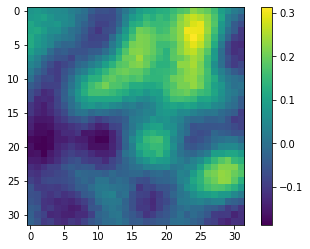

In [71]:
plt.imshow(dataset2[4][0]['x'].cpu())
plt.colorbar()

In [72]:
# Generate posterior estimator

post2 = swyft.Posteriors(dataset2)
partition = range(NPAR)
post2.add(partition, device='cuda', head_args = dict(online_norm = False), tail = RatioSampler, head = MyHead)

In [73]:
# train!

post2.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 64, optimizer_args = dict(lr = 0.01))

Training: lr=0.00063, Epoch=17, VL=450.7, TL=450.3


In [111]:
# Extract bounds from the tail

tail2 = list(post2._ratios.items())[0][1].tail
b02 = tail2.forward(x0, u0, return_bounds = 0.1)
b12 = tail2.forward(x0, u0, return_bounds = 0.9)
b2 = torch.vstack([b02, b12])
z_trunc2 = b2.T.cpu().detach().numpy()
#z_trunc = b[:, :N].cpu().detach().numpy().T

In [112]:
#z_trunc[:-33,:] *= 0.001
trunc2 = dict(z1 = z_trunc2[:4*4, :].reshape(4, 4, 2), z2 = z_trunc2[4*4:4*4+8*8, :].reshape(8, 8, 2), z3 = z_trunc2[4*4+8*8:, :].reshape(16, 16, 2))
draws2 = get_trunc_draws(100, trunc2)

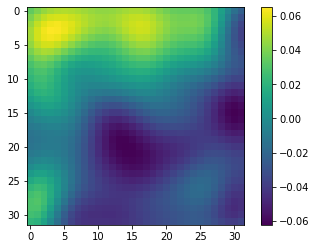

In [113]:
x = np.zeros((32, 32))
for i in range(100):
    d = draws2[i]
    u = np.zeros(NPAR)
    v = Viewer(view, u)
    v.z1 = d['z1']
    v.z2 = d['z2']
    v.z3 = d['z3']
    x += model(u)['x']
x /= 100
plt.imshow(x)
plt.colorbar()

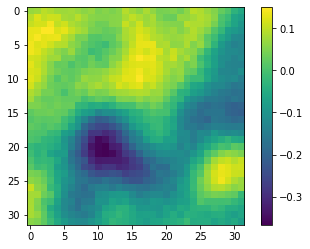

In [114]:
plt.imshow(X0)
plt.colorbar()